In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

liquid_triplets_df = pd.read_csv('../data/liquid_triplets_series_flat.csv')
butterfly_zcored = pd.read_csv('../data/butterfly_zcored.csv')

In [20]:
butterfly_zcored.dropna(inplace=True)
liquid_triplets_df.dropna(inplace=True)

In [23]:
butterfly_zcored['timestamp'] = pd.to_datetime(butterfly_zcored['timestamp'])


In [26]:
def butterfly_trading_strategy(butterfly_zcored, entry_threshold=2.0, exit_threshold=0.5, max_holding_period=1440, 
                             transaction_cost_pct=0.0005, notional_per_leg=10000):
    """
    Butterfly spread trading strategy based on z-score mean reversion
    
    Parameters:
    - entry_threshold: Z-score level to trigger entry (default 2.0)
    - exit_threshold: Z-score level to exit position (default 0.5)
    - max_holding_period: Maximum holding period in minutes (default 1440 = 24 hours)
    - transaction_cost_pct: Transaction cost as percentage of notional (default 0.05%)
    - notional_per_leg: Notional investment per leg in USD (default 10,000)
    """
    
    trades = []
    
    for triplet_key in butterfly_zcored[['tenor1_contract', 'tenor2_contract', 'tenor3_contract']].drop_duplicates().values:
        t1, t2, t3 = triplet_key
        
        triplet_data = butterfly_zcored[
            (butterfly_zcored['tenor1_contract'] == t1) &
            (butterfly_zcored['tenor2_contract'] == t2) &
            (butterfly_zcored['tenor3_contract'] == t3)
        ].copy().sort_values('timestamp')
        
        if len(triplet_data) == 0:
            continue
            
        position = 0  
        entry_time = None
        entry_price = None
        entry_zscore = None
        
        for idx, row in triplet_data.iterrows():
            current_zscore = row['fly_value_zscore']
            current_time = row['timestamp']
            current_price = row['fly_value']
            
            if pd.isna(current_zscore):
                continue
            
            if position == 0:
                if current_zscore > entry_threshold:
                    position = -1
                    entry_time = current_time
                    entry_price = current_price
                    entry_zscore = current_zscore
                    
                elif current_zscore < -entry_threshold:
                    position = 1
                    entry_time = current_time
                    entry_price = current_price
                    entry_zscore = current_zscore
            
            elif position != 0:
                should_exit = False
                exit_reason = ""
                
                if (position == 1 and current_zscore > -exit_threshold) or \
                   (position == -1 and current_zscore < exit_threshold):
                    should_exit = True
                    exit_reason = "mean_reversion"
                
                elif (current_time - entry_time).total_seconds() / 60 >= max_holding_period:
                    should_exit = True
                    exit_reason = "time_limit"
                
                elif (position == 1 and current_zscore < entry_zscore - 1.0) or \
                     (position == -1 and current_zscore > entry_zscore + 1.0):
                    should_exit = True
                    exit_reason = "stop_loss"
                
                if should_exit:
                    # Calculate gross PnL
                    gross_pnl = position * (current_price - entry_price)
                    
                    # Calculate transaction costs (entry + exit costs on 3 legs)
                    total_notional = 3 * notional_per_leg  # 3 legs in butterfly
                    transaction_costs = 2 * transaction_cost_pct * total_notional  # entry + exit
                    
                    # Net PnL after transaction costs
                    net_pnl = gross_pnl - transaction_costs
                    
                    holding_minutes = (current_time - entry_time).total_seconds() / 60
                    
                    trades.append({
                        'tenor1_contract': t1,
                        'tenor2_contract': t2,
                        'tenor3_contract': t3,
                        'entry_time': entry_time,
                        'exit_time': current_time,
                        'position': position,
                        'entry_zscore': entry_zscore,
                        'exit_zscore': current_zscore,
                        'entry_price': entry_price,
                        'exit_price': current_price,
                        'gross_pnl': gross_pnl,
                        'transaction_costs': transaction_costs,
                        'pnl': net_pnl,
                        'notional_per_leg': notional_per_leg,
                        'holding_minutes': holding_minutes,
                        'exit_reason': exit_reason
                    })
                    
                    position = 0
                    entry_time = None
                    entry_price = None
                    entry_zscore = None
    
    return pd.DataFrame(trades)

<Figure size 1400x800 with 0 Axes>

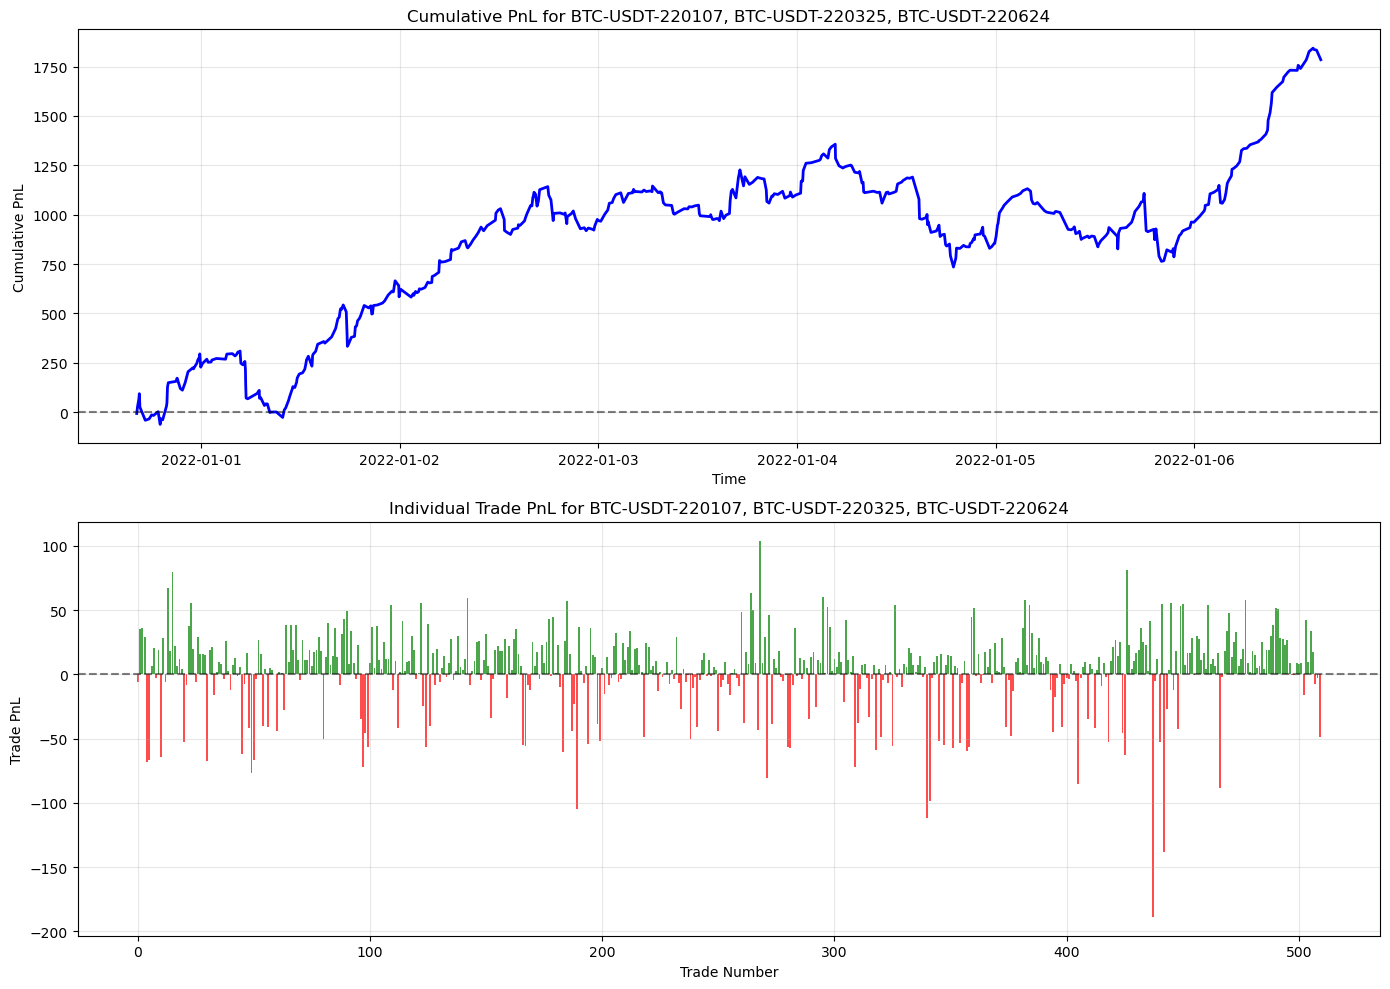

Statistics for BTC-USDT-220107, BTC-USDT-220325, BTC-USDT-220624:
  triplet: BTC-USDT-220107_BTC-USDT-220325_BTC-USDT-220624
  total_trades: 510
  total_pnl: 1784.3732
  win_rate: 0.6627
  avg_pnl: 3.4988
  ann_trade_sharpe: 1.7845
  mean_reversion_time: 3.7685
  median_reversion_time: 2.0000
  failure_rate: 0.6020
  avg_move: 2.8911
  avg_mae: -0.0257
  avg_mfe: 0.0906
  avg_edge_per_bar: 1.5090
  avg_rolling_sharpe: 1045.7447



<Figure size 1400x800 with 0 Axes>

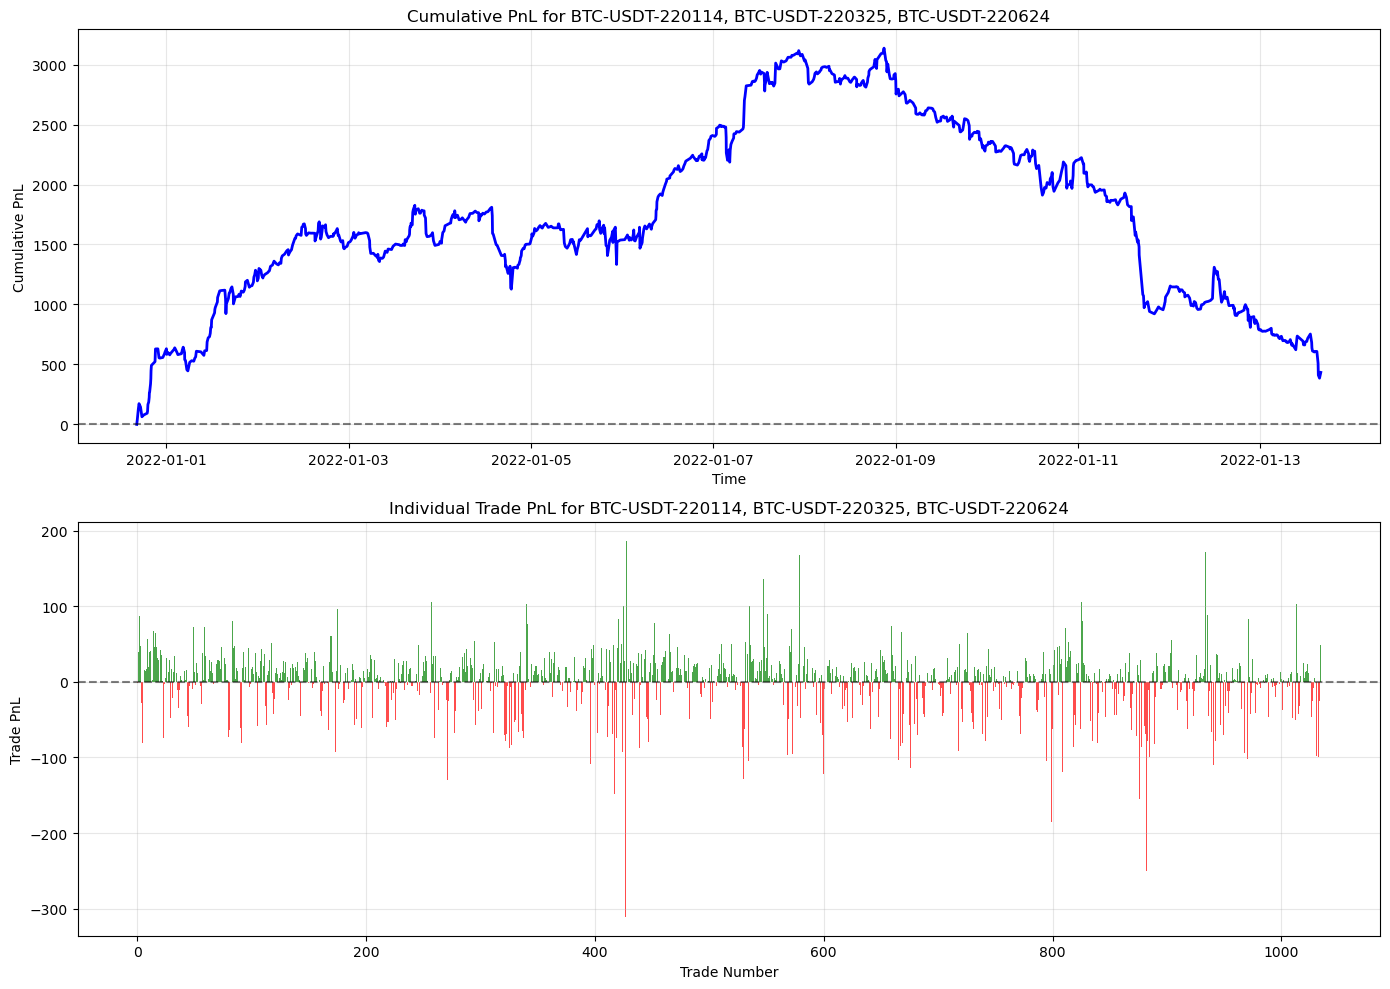

Statistics for BTC-USDT-220114, BTC-USDT-220325, BTC-USDT-220624:
  triplet: BTC-USDT-220114_BTC-USDT-220325_BTC-USDT-220624
  total_trades: 1035
  total_pnl: 432.3917
  win_rate: 0.6203
  avg_pnl: 0.4178
  ann_trade_sharpe: 0.1675
  mean_reversion_time: 4.5529
  median_reversion_time: 3.0000
  failure_rate: 0.6802
  avg_move: 2.8450
  avg_mae: -0.0617
  avg_mfe: 0.0782
  avg_edge_per_bar: 0.4572
  avg_rolling_sharpe: 1020.8693



<Figure size 1400x800 with 0 Axes>

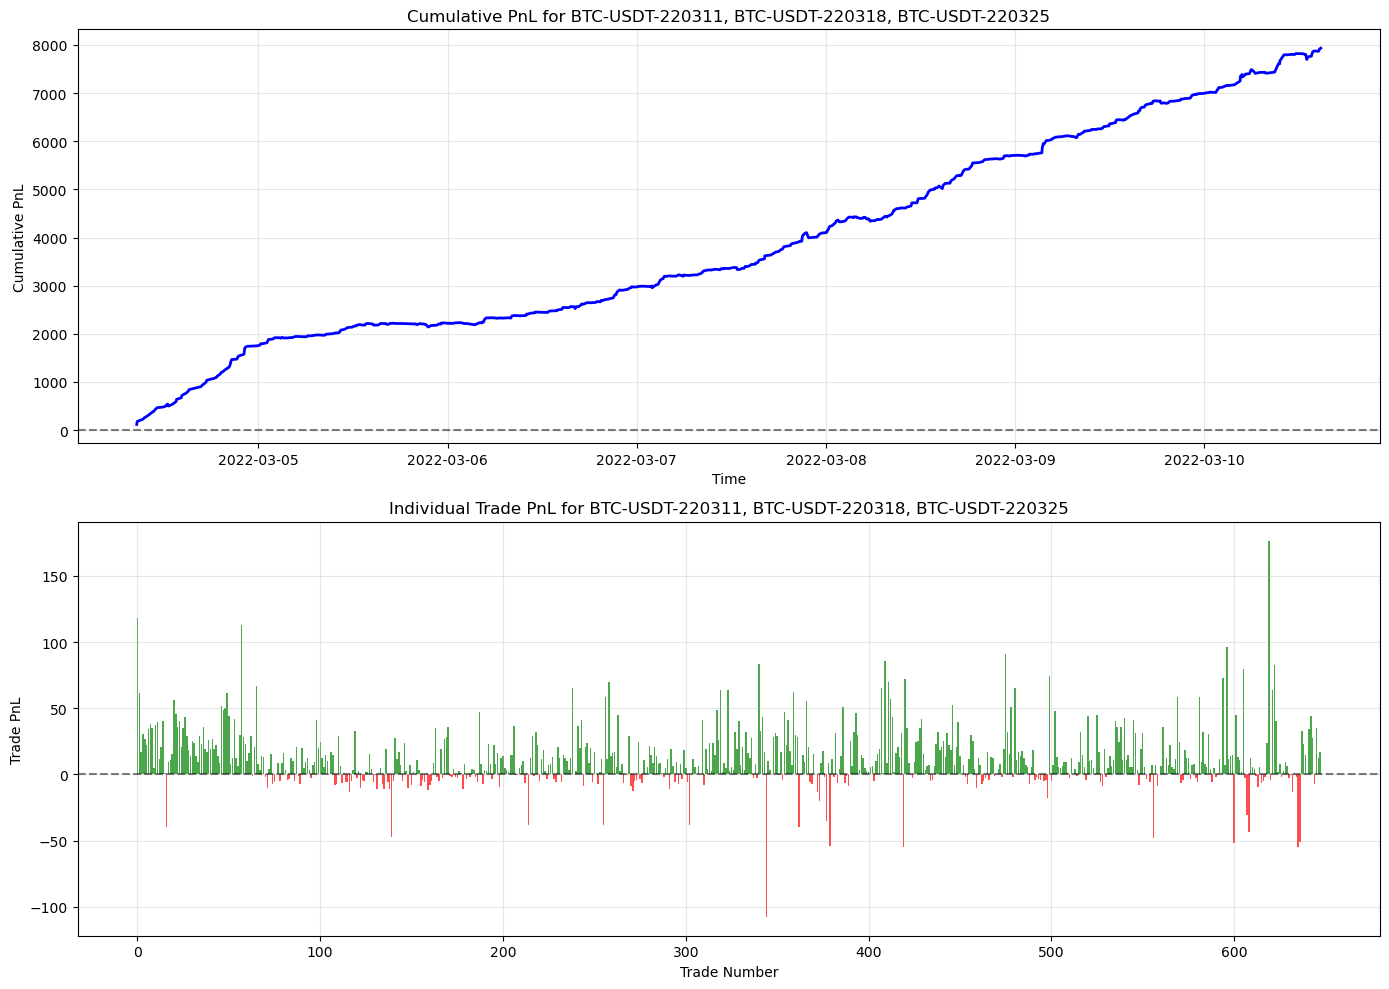

Statistics for BTC-USDT-220311, BTC-USDT-220318, BTC-USDT-220325:
  triplet: BTC-USDT-220311_BTC-USDT-220318_BTC-USDT-220325
  total_trades: 648
  total_pnl: 7934.1000
  win_rate: 0.7299
  avg_pnl: 12.2440
  ann_trade_sharpe: 8.6275
  mean_reversion_time: 1.9474
  median_reversion_time: 1.0000
  failure_rate: 0.3843
  avg_move: 3.3377
  avg_mae: 0.0051
  avg_mfe: 0.1823
  avg_edge_per_bar: 5.1929
  avg_rolling_sharpe: 1331.4200



<Figure size 1400x800 with 0 Axes>

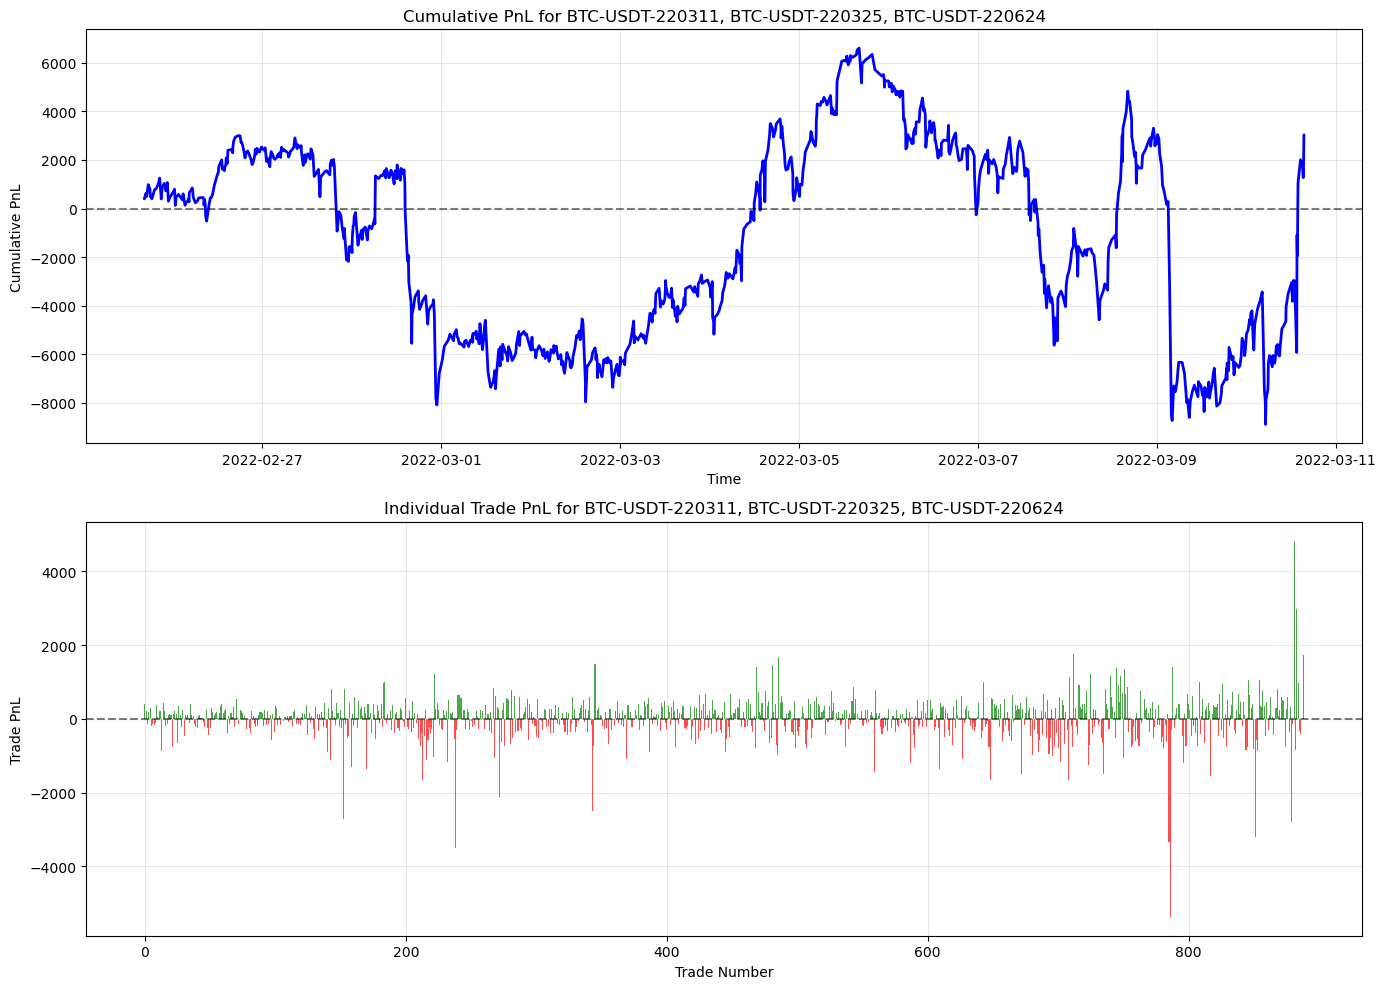

Statistics for BTC-USDT-220311, BTC-USDT-220325, BTC-USDT-220624:
  triplet: BTC-USDT-220311_BTC-USDT-220325_BTC-USDT-220624
  total_trades: 889
  total_pnl: 3021.9427
  win_rate: 0.5658
  avg_pnl: 3.3993
  ann_trade_sharpe: 0.0910
  mean_reversion_time: 7.2333
  median_reversion_time: 5.0000
  failure_rate: 0.8313
  avg_move: 2.8631
  avg_mae: -0.1443
  avg_mfe: 0.3864
  avg_edge_per_bar: -9.8790
  avg_rolling_sharpe: 14022.8694



<Figure size 1400x800 with 0 Axes>

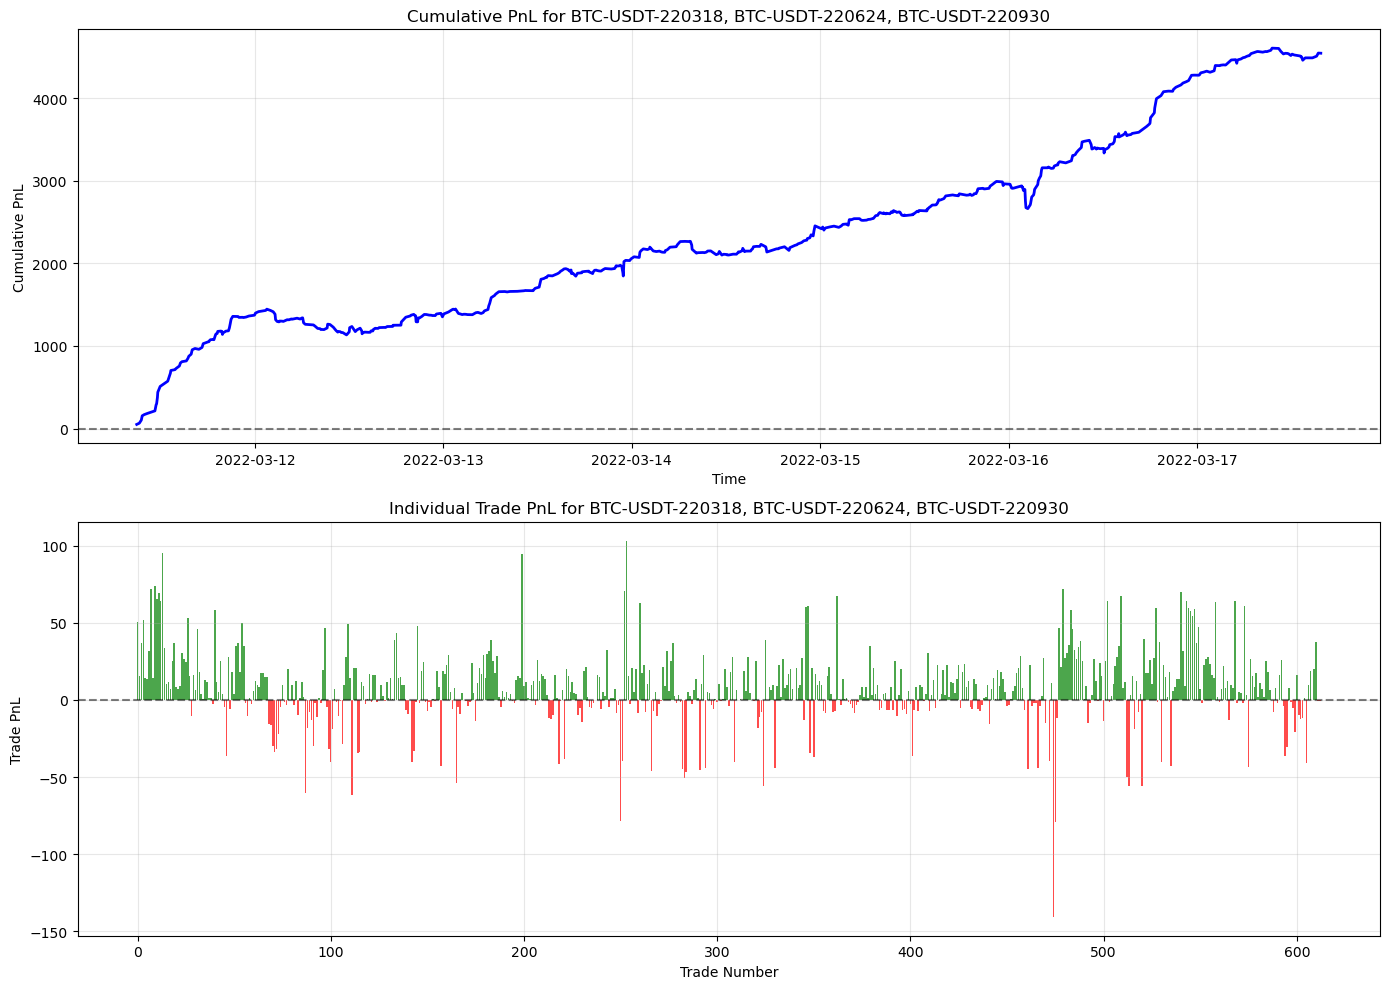

Statistics for BTC-USDT-220318, BTC-USDT-220624, BTC-USDT-220930:
  triplet: BTC-USDT-220318_BTC-USDT-220624_BTC-USDT-220930
  total_trades: 613
  total_pnl: 4544.2000
  win_rate: 0.6688
  avg_pnl: 7.4131
  ann_trade_sharpe: 4.9088
  mean_reversion_time: 2.4116
  median_reversion_time: 2.0000
  failure_rate: 0.4649
  avg_move: 3.0212
  avg_mae: -0.0320
  avg_mfe: 0.0419
  avg_edge_per_bar: 3.1043
  avg_rolling_sharpe: 1073.8698



<Figure size 1400x800 with 0 Axes>

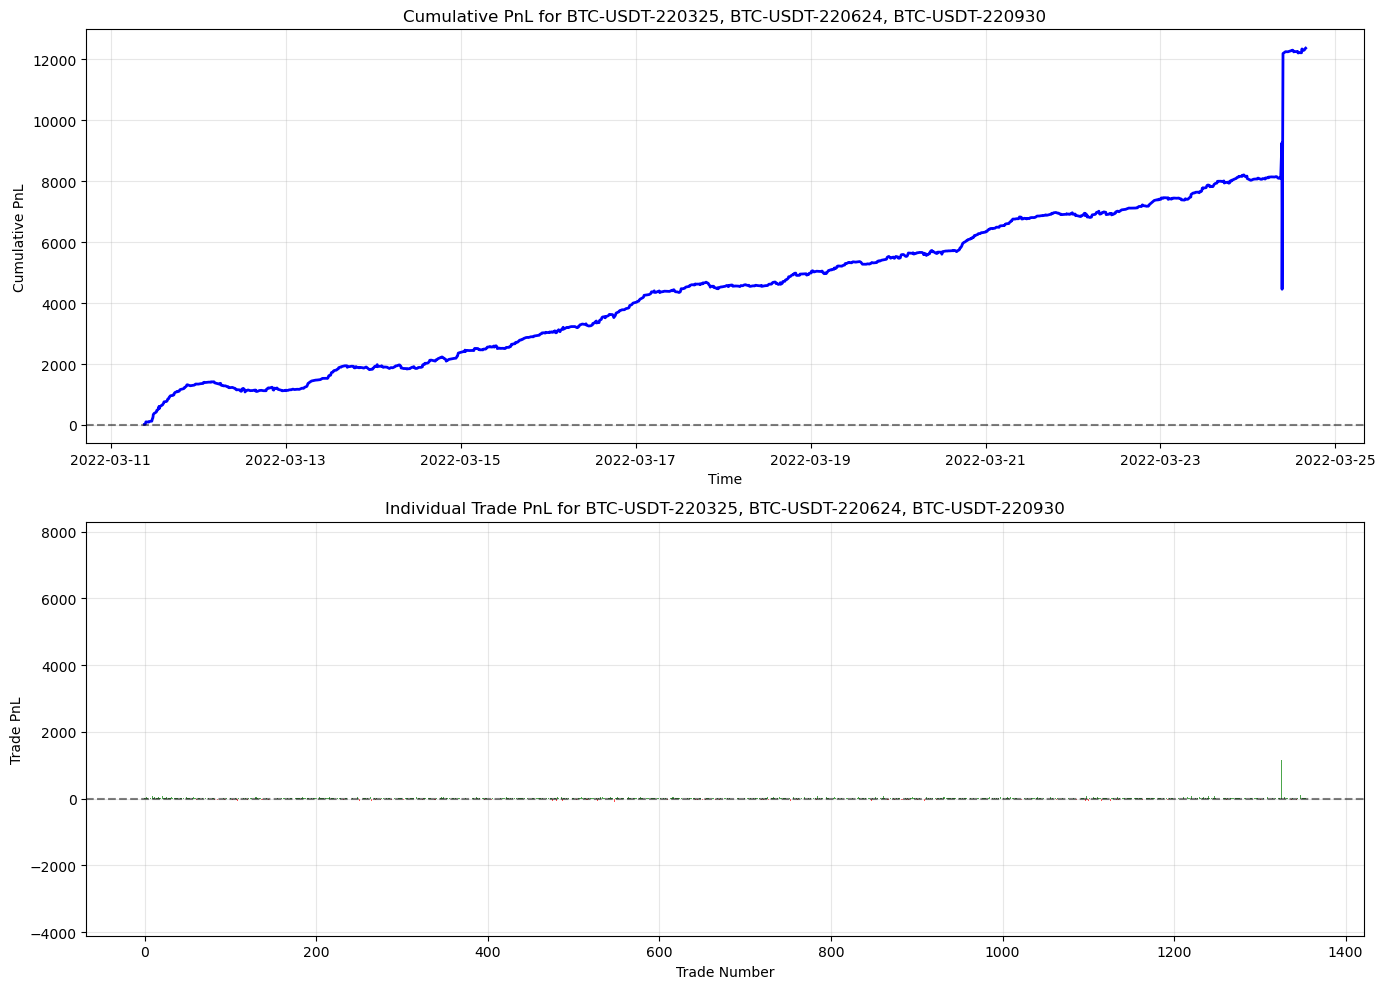

Statistics for BTC-USDT-220325, BTC-USDT-220624, BTC-USDT-220930:
  triplet: BTC-USDT-220325_BTC-USDT-220624_BTC-USDT-220930
  total_trades: 1354
  total_pnl: 12363.3172
  win_rate: 0.6743
  avg_pnl: 9.1310
  ann_trade_sharpe: 0.6120
  mean_reversion_time: 2.5803
  median_reversion_time: 2.0000
  failure_rate: 0.4668
  avg_move: 3.8275
  avg_mae: -0.2431
  avg_mfe: 0.4306
  avg_edge_per_bar: 2.1471
  avg_rolling_sharpe: 1521.0969



<Figure size 1400x800 with 0 Axes>

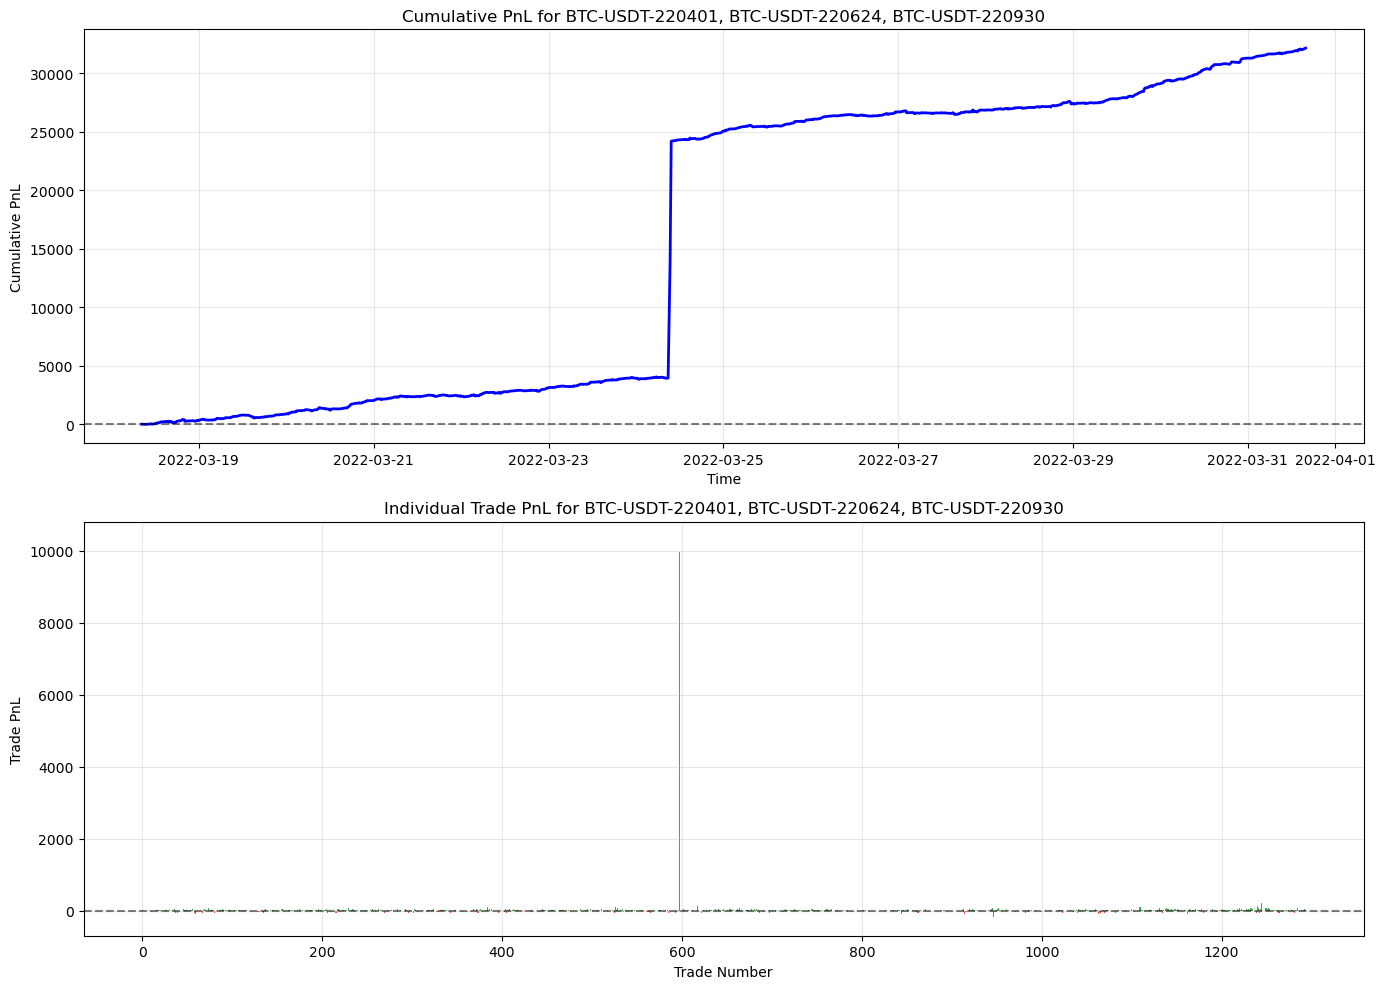

Statistics for BTC-USDT-220401, BTC-USDT-220624, BTC-USDT-220930:
  triplet: BTC-USDT-220401_BTC-USDT-220624_BTC-USDT-220930
  total_trades: 1294
  total_pnl: 32132.8486
  win_rate: 0.7009
  avg_pnl: 24.8322
  ann_trade_sharpe: 0.9899
  mean_reversion_time: 2.5876
  median_reversion_time: 2.0000
  failure_rate: 0.4884
  avg_move: 4.5429
  avg_mae: -0.0077
  avg_mfe: 0.2069
  avg_edge_per_bar: 8.6363
  avg_rolling_sharpe: 2849.0041



<Figure size 1400x800 with 0 Axes>

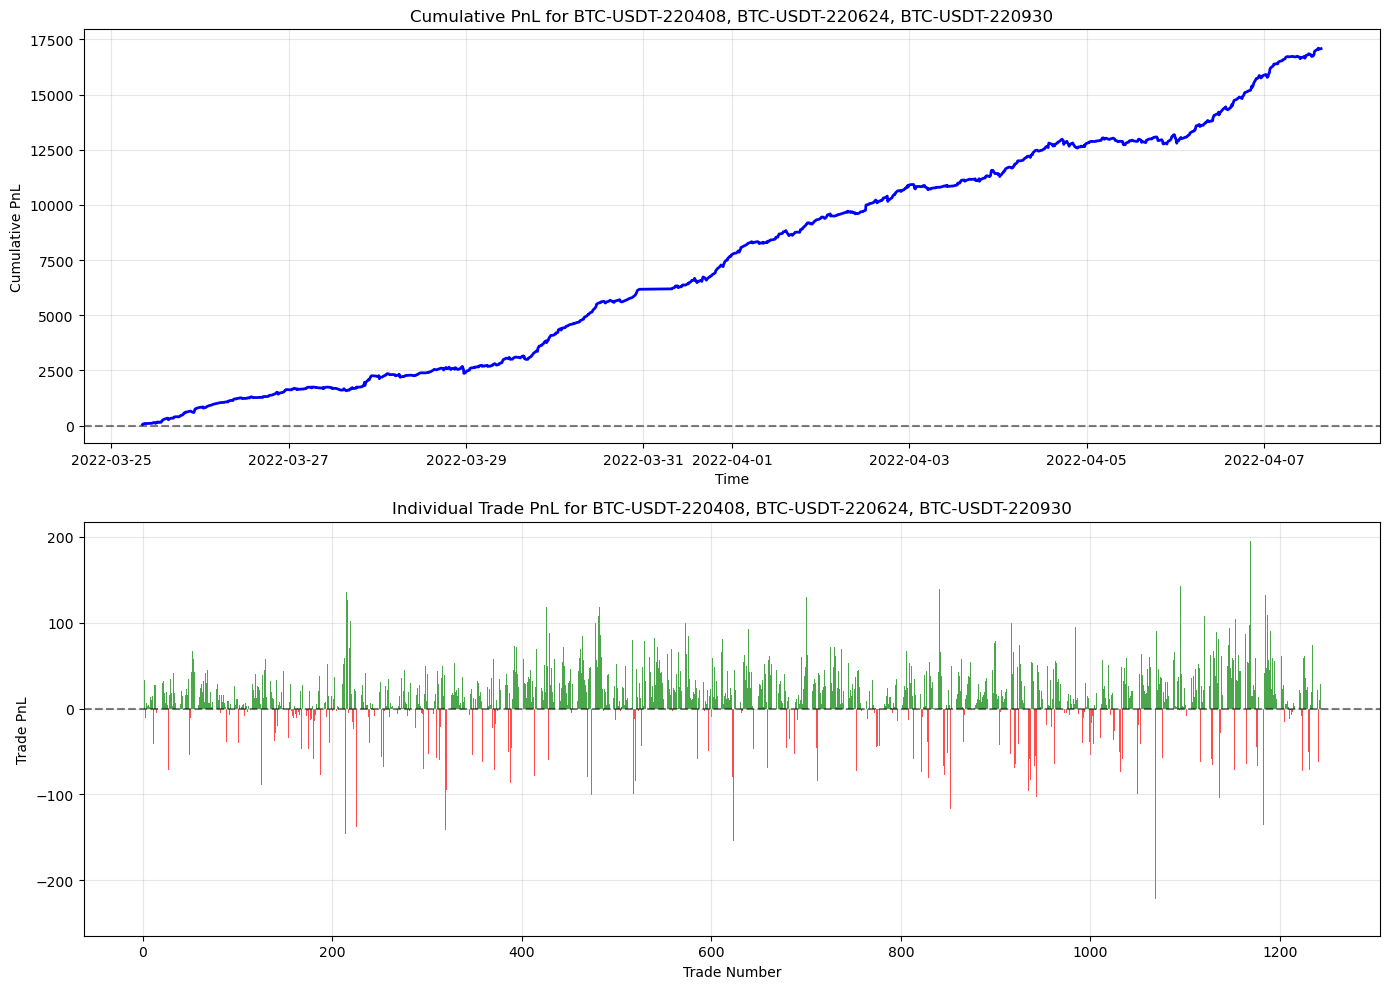

Statistics for BTC-USDT-220408, BTC-USDT-220624, BTC-USDT-220930:
  triplet: BTC-USDT-220408_BTC-USDT-220624_BTC-USDT-220930
  total_trades: 1244
  total_pnl: 17082.6137
  win_rate: 0.7685
  avg_pnl: 13.7320
  ann_trade_sharpe: 5.5515
  mean_reversion_time: 3.0938
  median_reversion_time: 2.0000
  failure_rate: 0.5113
  avg_move: 3.1389
  avg_mae: 0.0416
  avg_mfe: 0.0249
  avg_edge_per_bar: 5.5975
  avg_rolling_sharpe: 2000.1376



<Figure size 1400x800 with 0 Axes>

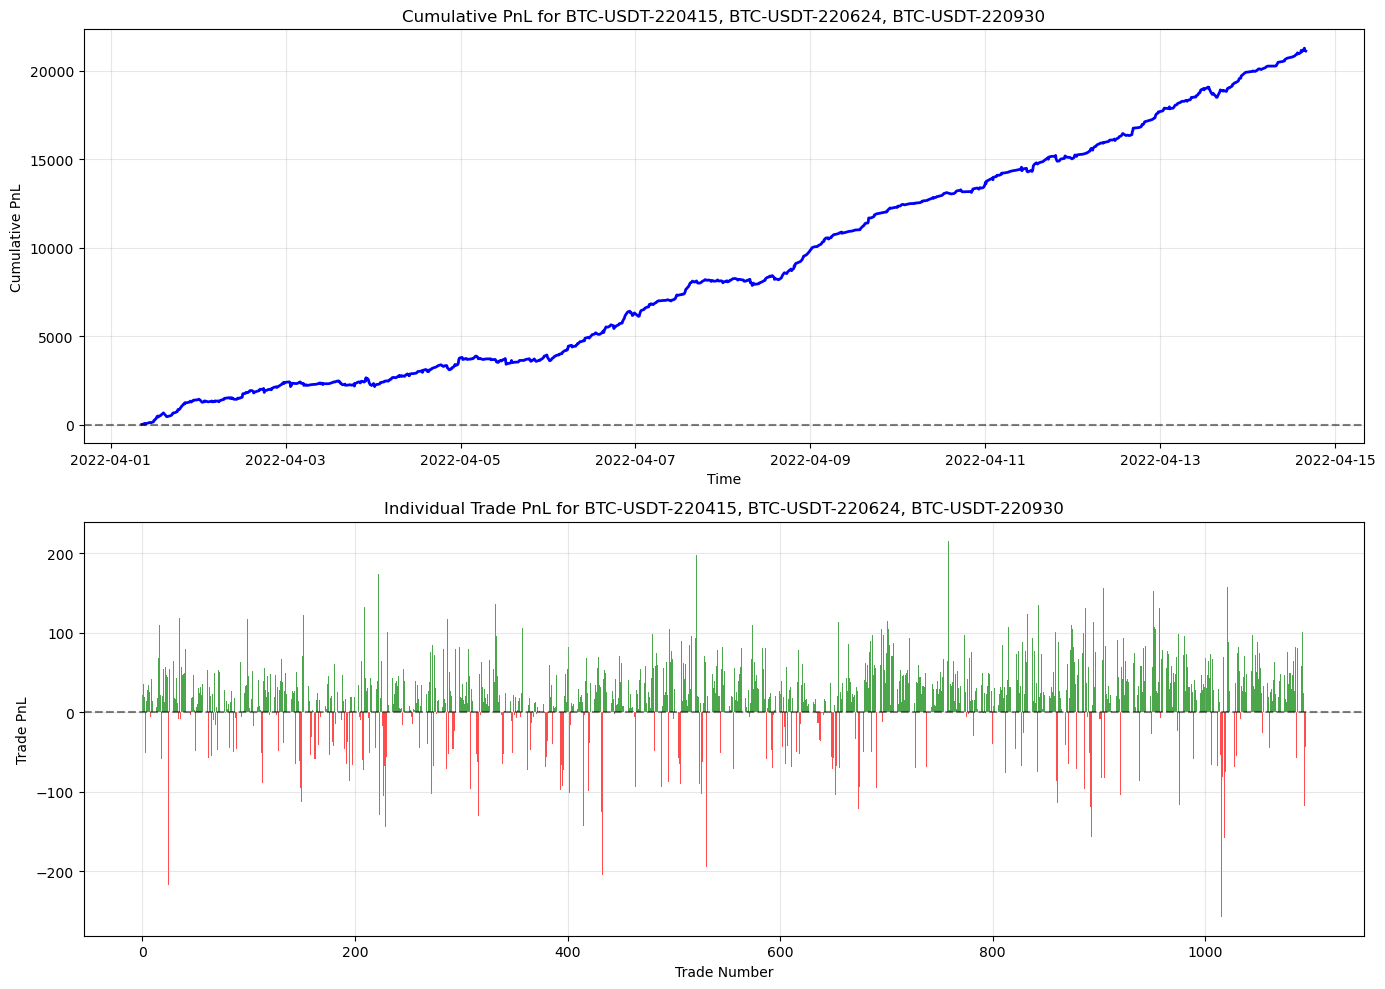

Statistics for BTC-USDT-220415, BTC-USDT-220624, BTC-USDT-220930:
  triplet: BTC-USDT-220415_BTC-USDT-220624_BTC-USDT-220930
  total_trades: 1095
  total_pnl: 21122.7763
  win_rate: 0.7781
  avg_pnl: 19.2902
  ann_trade_sharpe: 5.9863
  mean_reversion_time: 3.3282
  median_reversion_time: 2.0000
  failure_rate: 0.5881
  avg_move: 2.9111
  avg_mae: 0.0243
  avg_mfe: -0.0345
  avg_edge_per_bar: 7.1621
  avg_rolling_sharpe: 2741.4068



<Figure size 1400x800 with 0 Axes>

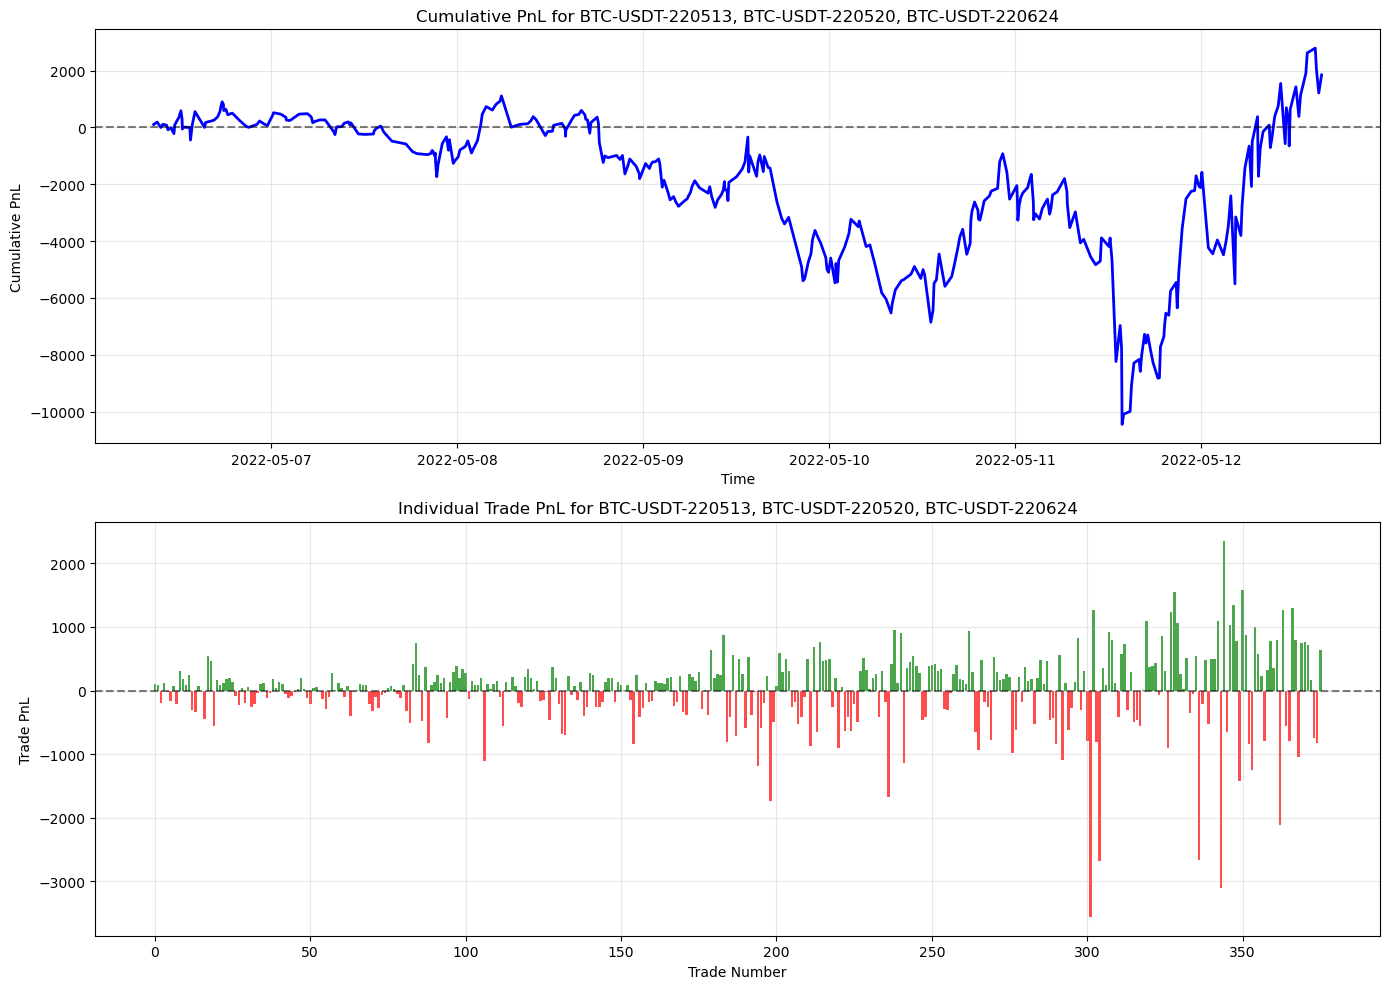

Statistics for BTC-USDT-220513, BTC-USDT-220520, BTC-USDT-220624:
  triplet: BTC-USDT-220513_BTC-USDT-220520_BTC-USDT-220624
  total_trades: 376
  total_pnl: 1850.0239
  win_rate: 0.5904
  avg_pnl: 4.9203
  ann_trade_sharpe: 0.1297
  mean_reversion_time: 8.3462
  median_reversion_time: 5.5000
  failure_rate: 0.8617
  avg_move: 2.5659
  avg_mae: -0.0841
  avg_mfe: 0.1599
  avg_edge_per_bar: -1.6397
  avg_rolling_sharpe: 13003.1467



<Figure size 1400x800 with 0 Axes>

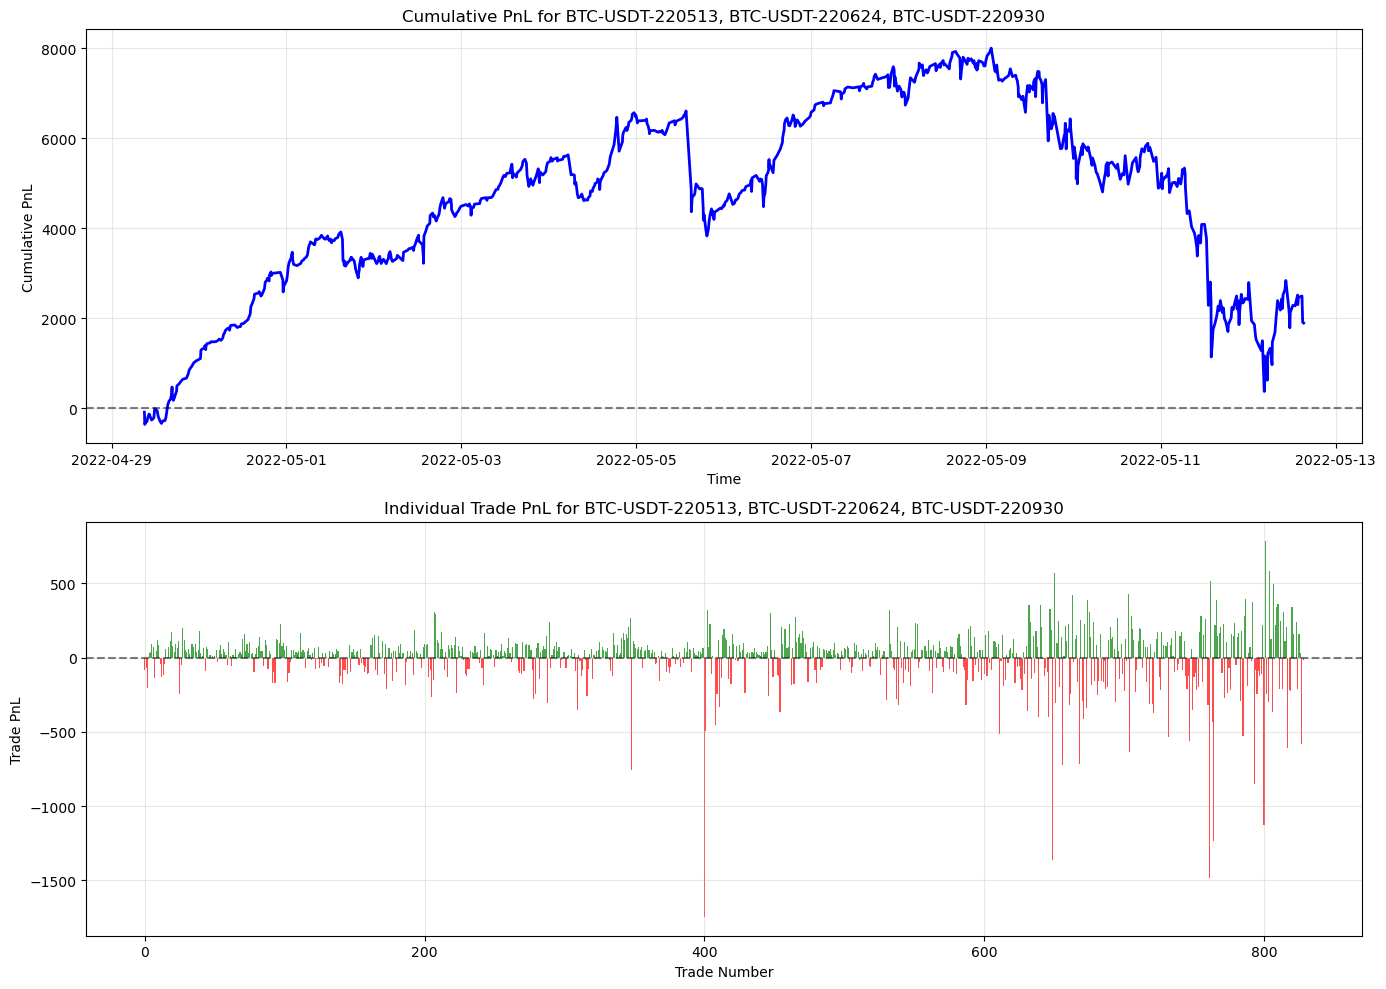

Statistics for BTC-USDT-220513, BTC-USDT-220624, BTC-USDT-220930:
  triplet: BTC-USDT-220513_BTC-USDT-220624_BTC-USDT-220930
  total_trades: 829
  total_pnl: 1895.2131
  win_rate: 0.6538
  avg_pnl: 2.2861
  ann_trade_sharpe: 0.1863
  mean_reversion_time: 7.2151
  median_reversion_time: 4.0000
  failure_rate: 0.7756
  avg_move: 2.6879
  avg_mae: 0.0296
  avg_mfe: 0.0032
  avg_edge_per_bar: -0.5686
  avg_rolling_sharpe: 4252.5195



In [30]:
for idx, row in liquid_triplets_df.iterrows():
    t1, t2, t3 = row['tenor1_contract'], row['tenor2_contract'], row['tenor3_contract']

    triplet_df = butterfly_zcored[
        (butterfly_zcored['tenor1_contract'] == t1) &
        (butterfly_zcored['tenor2_contract'] == t2) &
        (butterfly_zcored['tenor3_contract'] == t3)
    ].copy()

    trades_df = butterfly_trading_strategy(triplet_df, transaction_cost_pct=0.0004, notional_per_leg=10000)

    if len(trades_df) > 0 and trades_df['pnl'].sum() > 0:
        trades_df['cumulative_pnl'] = trades_df['pnl'].cumsum()
        
        plt.figure(figsize=(14, 8))
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        ax1.plot(trades_df['exit_time'], trades_df['cumulative_pnl'], linewidth=2, color='blue')
        ax1.set_title(f'Cumulative PnL for {t1}, {t2}, {t3}')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Cumulative PnL')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        colors = ['green' if pnl > 0 else 'red' for pnl in trades_df['pnl']]
        ax2.bar(range(len(trades_df)), trades_df['pnl'], color=colors, alpha=0.7)
        ax2.set_title(f'Individual Trade PnL for {t1}, {t2}, {t3}')
        ax2.set_xlabel('Trade Number')
        ax2.set_ylabel('Trade PnL')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        total_pnl = trades_df['pnl'].sum()
        win_rate = (trades_df['pnl'] > 0).mean()
        avg_pnl = trades_df['pnl'].mean()
        
        if trades_df['pnl'].std() > 0:
            ann_trade_sharpe = (trades_df['pnl'].mean() / trades_df['pnl'].std()) * np.sqrt(252)
        else:
            ann_trade_sharpe = 0
        
        stats_list = []
        for _, trade in trades_df.iterrows():
            trade_data = triplet_df[
                (triplet_df['timestamp'] >= trade['entry_time']) & 
                (triplet_df['timestamp'] <= trade['exit_time'])
            ].copy()
            
            if len(trade_data) > 0:
                if trade['position'] == 1: 
                    reversion_mask = trade_data['fly_value_zscore'] >= 0
                else:  
                    reversion_mask = trade_data['fly_value_zscore'] <= 0
                
                reversion_time = None
                if reversion_mask.any():
                    reversion_idx = trade_data[reversion_mask].index[0]
                    entry_idx = trade_data.index[0]
                    reversion_time = trade_data.loc[reversion_idx, 'timestamp'] - trade_data.loc[entry_idx, 'timestamp']
                    reversion_time = reversion_time.total_seconds() / 60  
                
                spread_move = abs(trade['exit_zscore'] - trade['entry_zscore'])
                
                if trade['position'] == 1:
                    max_adverse = (trade_data['fly_value_zscore'] - trade['entry_zscore']).min()
                    max_favorable = (trade_data['fly_value_zscore'] - trade['entry_zscore']).max()
                else:
                    max_adverse = (trade_data['fly_value_zscore'] - trade['entry_zscore']).max()
                    max_favorable = (trade_data['fly_value_zscore'] - trade['entry_zscore']).min()
                
                edge_per_bar = trade['pnl'] / len(trade_data) if len(trade_data) > 0 else 0
                trade_sharpe = trade['pnl'] / max(abs(max_adverse), 0.01)
                
                stats_list.append({
                    'reversion_time': reversion_time,
                    'spread_move': spread_move,
                    'max_adverse': max_adverse,
                    'max_favorable': max_favorable,
                    'edge_per_bar': edge_per_bar,
                    'trade_sharpe': trade_sharpe
                })
        
        stats_df = pd.DataFrame(stats_list)
        
        triplet_stats = {
            'triplet': f"{t1}_{t2}_{t3}",
            'total_trades': len(trades_df),
            'total_pnl': total_pnl,
            'win_rate': win_rate,
            'avg_pnl': avg_pnl,
            'ann_trade_sharpe': ann_trade_sharpe,
            'mean_reversion_time': stats_df['reversion_time'].dropna().mean() if len(stats_df) > 0 else np.nan,
            'median_reversion_time': stats_df['reversion_time'].dropna().median() if len(stats_df) > 0 else np.nan,
            'failure_rate': stats_df['reversion_time'].isna().mean() if len(stats_df) > 0 else np.nan,
            'avg_move': stats_df['spread_move'].mean() if len(stats_df) > 0 else np.nan,
            'avg_mae': stats_df['max_adverse'].mean() if len(stats_df) > 0 else np.nan,
            'avg_mfe': stats_df['max_favorable'].mean() if len(stats_df) > 0 else np.nan,
            'avg_edge_per_bar': stats_df['edge_per_bar'].mean() if len(stats_df) > 0 else np.nan,
            'avg_rolling_sharpe': stats_df['trade_sharpe'].mean() if len(stats_df) > 0 else np.nan
        }
        
        print(f"Statistics for {t1}, {t2}, {t3}:")
        for key, value in triplet_stats.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")
        print()